In [1]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline
from astroML.plotting          import hist
from astropy.io                import fits
from astropy.modeling          import models, fitting
from datetime                  import datetime
from image_registration        import cross_correlation_shifts
from glob                      import glob
from functools                 import partial
from matplotlib.ticker         import MaxNLocator
from matplotlib                import style
from os                        import listdir
# from least_asymmetry.asym      import actr, moments, fitgaussian
from multiprocessing           import cpu_count, Pool
from numpy                     import min as npmin, max as npmax, zeros, arange, sum, float, isnan, hstack
from numpy                     import int32 as npint, round as npround, nansum as sum, nanstd as std
from os                        import environ, path, mkdir
from pandas                    import DataFrame, read_csv, read_pickle, scatter_matrix
from photutils                 import CircularAperture, CircularAnnulus, aperture_photometry, findstars
from pylab                     import ion, gcf, sort, linspace, indices, median, mean, std, empty, figure, transpose, ceil
from pylab                     import concatenate, pi, sqrt, ones, diag, inf, rcParams, isnan, isfinite, array, nanmax
from pylab                     import figure, plot, imshow, scatter, legend
from seaborn                   import *
from scipy.special             import erf
from scipy                     import stats
from sklearn.cluster           import DBSCAN
from sklearn.externals         import joblib
from sklearn.preprocessing     import StandardScaler
from socket                    import gethostname
from statsmodels.robust        import scale
from statsmodels.nonparametric import kde
from sys                       import exit
from time                      import time, localtime
from tqdm                      import tqdm_notebook

from numpy                     import zeros, nanmedian as median, nanmean as mean, nan
from sys                       import exit
from sklearn.externals         import joblib

import numpy as np

In [3]:
startFull = time()

**Master Class for Exoplanet Time Series Observation Photometry**

In [6]:
from ExoplanetTSO_Auxiliary import wanderer

In [7]:
def clipOutlier2D(arr2D, nSig=10):
    arr2D     = arr2D.copy()
    medArr2D  = median(arr2D,axis=0)
    sclArr2D  = np.sqrt(((scale.mad(arr2D)**2.).sum()))
    outliers  = abs(arr2D - medArr2D) >  nSig*sclArr2D
    inliers   = abs(arr2D - medArr2D) <= nSig*sclArr2D
    arr2D[outliers] = median(arr2D[inliers],axis=0)
    return arr2D

In [8]:
rcParams['figure.dpi'] = 150
rcParams['image.interpolation'] = 'None'
rcParams['image.cmap']          = 'Blues_r'
rcParams['axes.grid']           = False

As an example, Spitzer data is expected to be store in the directory structure:

`$HOME/PLANET_DIRECTORY/PLANETNAME/data/raw/AORDIR/CHANNEL/bcd/`

EXAMPLE:

1. On a Linux machine
2. With user `tempuser`,
3. And all Spitzer data is store in `Research/Planets`
4. The planet named `Happy-5b`
5. Observed during AOR r11235813
6. In CH2 (4.5 microns)

The `loadfitsdir` should read as: `/home/tempuser/Research/Planets/HAPPY5/data/raw/r11235813/ch2/bcd/`

In [28]:
from os import environ

planetName      = 'GJ1214'
planetDirectory = '/Research/Planets/'

channel = 'ch2'
# channel = 'ch2/'

dataSub = 'bcd/'

dataDir     = environ['HOME'] + planetDirectory + planetName + '/data/raw/' + channel + '/big/'

AORs = []
for dirNow in glob(dataDir + '/*'):
    AORs.append(dirNow.split('/')[-1])

fileExt = '*bcd.fits'
uncsExt = '*bunc.fits'

print(dataDir)

/Users/jfraine/Research/Planets/GJ1214/data/raw/ch2/big/


In [31]:
len(AORs)

25

In [35]:
iAOR        = 0
AORNow      = AORs[iAOR]
loadfitsdir = dataDir + AORNow + '/' + channel + '/' + dataSub
print(loadfitsdir)

/Users/jfraine/Research/Planets/GJ1214/data/raw/ch2/big/r42048000/ch2/bcd/


In [36]:
nCores = cpu_count()

In [37]:
fitsFilenames = glob(loadfitsdir + fileExt);print(len(fitsFilenames))
uncsFilenames = glob(loadfitsdir + uncsExt);print(len(uncsFilenames))

472
472


In [38]:
header_test = fits.getheader(fitsFilenames[0])
print('AORLABEL:\t{}\nNum Fits Files:\t{}\nNum Unc Files:\t{}'.format\
          (header_test['AORLABEL'], len(fitsFilenames), len(uncsFilenames)))

AORLABEL:	p70049_GJ1214_ch2_c_65hr_pt3_ier
Num Fits Files:	472
Num Unc Files:	472


# Load ExoplanetTSO Class

Necessary Constants Spitzer
---

In [39]:
ppm             = 1e6
y,x             = 0,1

yguess, xguess  = 15., 15.   # Specific to Spitzer circa 2010 and beyond
filetype        = 'bcd.fits' # Specific to Spitzer Basic Calibrated Data

Load Stored Instance from Save Files
---

If this is **not** your time, then you can load a saved file in the `loadfitsdir` directory that has the filename:

`PLANETNAME_Wanderer_METHOD_DATE.pickle.save` 

```python
method = 'mean'
example_wanderer_mean = wanderer(loadfitsdir=loadfitsdir, filetype=filetype, 
                                            yguess=yguess, xguess=xguess, method=method)

example_wanderer_mean.load_data_from_save_files(savefiledir='./SaveFiles/', 
                        saveFileNameHeader=planetName+'_Wanderer_Mean_', saveFileType='.pickle.save')
```

```python
method = 'median'
example_wanderer_median = wanderer(loadfitsdir=loadfitsdir_ModA, filetype=filetype, 
                                            yguess=yguess, xguess=xguess, method=method)

example_wanderer_median.load_data_from_save_files(savefiledir='./SaveFiles/', saveFileNameHeader='Example_Wanderer_Median_', saveFileType='.pickle.save')
```

Start a New Instance with Median for the Metric
---

In [40]:
method = 'median'

print('Initialize an instance of `wanderer` as `example_wanderer_median`\n')
example_wanderer_median = wanderer(fitsFileDir=loadfitsdir, filetype=filetype, telescope='Spitzer', 
                                            yguess=yguess, xguess=xguess, method=method, nCores=nCores)

example_wanderer_median.AOR        = AORNow
example_wanderer_median.planetName = planetName
example_wanderer_median.channel    = channel

Initialize an instance of `wanderer` as `example_wanderer_median`



** Not all who wander are lost **


Completed Class Definition at 2018-7-17 12h50m57s


In [41]:
print('Load Data From Fits Files in ' + loadfitsdir + '\n')
# exarymple_wanderer_median.load_data_from_fits_files()
example_wanderer_median.spitzer_load_fits_file(outputUnits='electrons')#(outputUnits='muJ_per_Pixel')

Load Data From Fits Files in /Users/jfraine/Research/Planets/GJ1214/data/raw/ch2/big/r42048000/ch2/bcd/

Loading Spitzer Data


/Users/jfraine/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [42]:
print('Skipping Load Data From Save Files in ' + loadfitsdir + '\n')
# example_wanderer_median.load_data_from_save_files(savefiledir='./SaveFiles/', \
# saveFileNameHeader='Example_Wanderer_Median_', saveFileType='.pickle.save')

Skipping Load Data From Save Files in /Users/jfraine/Research/Planets/GJ1214/data/raw/ch2/big/r42048000/ch2/bcd/



**Double check for NaNs**

In [43]:
example_wanderer_median.imageCube[np.where(isnan(example_wanderer_median.imageCube))] = \
                                                    np.nanmedian(example_wanderer_median.imageCube)

**Identifier Strong Outliers**

In [44]:
print('Find, flag, and NaN the "Bad Pixels" Outliers' + '\n')
example_wanderer_median.find_bad_pixels()

Find, flag, and NaN the "Bad Pixels" Outliers

There are 22879 'Hot' Pixels


In [45]:
print('Fit for All Centers: Flux Weighted, Gaussian Fitting, Gaussian Moments, Least Asymmetry' + '\n')
# example_wanderer_median.fit_gaussian_centering()
example_wanderer_median.fit_flux_weighted_centering()
# example_wanderer_median.fit_least_asymmetry_centering()
# example_wanderer_median.fit_all_centering() # calling this calls least_asymmetry, which does not work :(

Fit for All Centers: Flux Weighted, Gaussian Fitting, Gaussian Moments, Least Asymmetry

(30208, 32, 32)


In [46]:
# start = time()
# example_wanderer_median.mp_fit_gaussian_centering(subArray=6)
# print('Operation took {} seconds with {} cores'.format(time()-start, example_wanderer_median.nCores))

# centering_df_copy = example_wanderer_median.centering_df
# example_wanderer_median.centering_df = {}

start = time()
example_wanderer_median.mp_lmfit_gaussian_centering(subArraySize=6, recheckMethod=None, median_crop=False)
print('Operation took {} seconds with {} cores'.format(time()-start, example_wanderer_median.nCores))

Finished with Fitting Centers. Now assigning to instance values.
Operation took 179.81528282165527 seconds with 12 cores


In [69]:
nSig       = 10.1
medY       = median(example_wanderer_median.centering_GaussianFit.T[y])
medX       = median(example_wanderer_median.centering_GaussianFit.T[x])
stdY       = std(example_wanderer_median.centering_GaussianFit.T[y])
stdX       = std(example_wanderer_median.centering_GaussianFit.T[x])

ySig = 4
xSig = 4
outliers   = (((example_wanderer_median.centering_GaussianFit.T[y] - medY)/(ySig*stdY))**2 + \
              ((example_wanderer_median.centering_GaussianFit.T[x] - medX)/(xSig*stdX))**2) > 1

(14.327911031335907, 15.353219839908649)

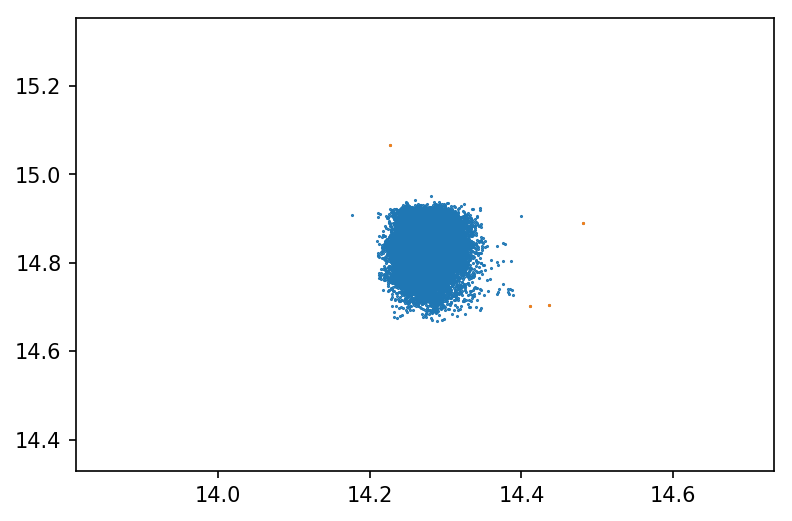

In [70]:
ax = figure().add_subplot(111)
cx, cy = example_wanderer_median.centering_GaussianFit.T[x],example_wanderer_median.centering_GaussianFit.T[y]
ax.plot(cx,cy,'.',ms=1)
ax.plot(cx[outliers],cy[outliers],'.',ms=1)
# ax.plot(median(cx), median(cy),'ro',ms=1)
ax.set_xlim(medX-nSig*stdX,medX+nSig*stdX)
ax.set_ylim(medY-nSig*stdY,medY+nSig*stdY)

In [71]:
from sklearn.cluster import DBSCAN

dbs     = DBSCAN(n_jobs=-1, eps=0.2, leaf_size=10)
dbsPred = dbs.fit_predict(example_wanderer_median.centering_GaussianFit)

In [72]:
dbs_options = [k for k in range(-1,100) if (dbsPred==k).sum()]

In [73]:
dbs_options

[-1, 0, 1]

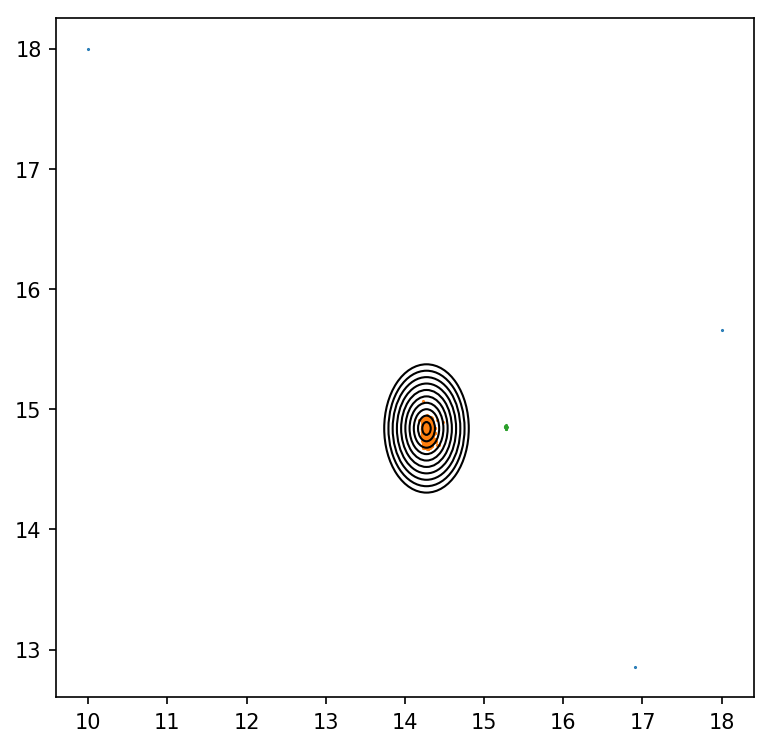

In [79]:
fig = figure(figsize=(6,6))
ax  = fig.add_subplot(111)

medGaussCenters   = median(example_wanderer_median.centering_GaussianFit,axis=0)
sclGaussCenters   = scale.mad(example_wanderer_median.centering_GaussianFit)
sclGaussCenterAvg = np.sqrt(((sclGaussCenters**2.).sum()))

yctrs = example_wanderer_median.centering_GaussianFit.T[y]
xctrs = example_wanderer_median.centering_GaussianFit.T[x]

nSigmas         = 5
for nSig in linspace(1,10,10):
    CircularAperture(medGaussCenters[::-1],nSig*sclGaussCenterAvg).plot(ax=ax)

for dbsOpt in dbs_options:
    ax.plot(xctrs[dbsPred==dbsOpt], yctrs[dbsPred==dbsOpt],'.',zorder=0, ms=1)

In [80]:
npix = 3

stillOutliers = np.where(abs(example_wanderer_median.centering_GaussianFit - medGaussCenters) > 4*sclGaussCenterAvg)[0]
print(len(stillOutliers))
# for o in stillOutliers:
#     figure()
#     imshow(example_wanderer_median.imageCube[o][16-npix:16+npix+1,16-npix:16+npix+1])

18


In [81]:
dbsClean  = 0
dbsKeep   = (dbsPred == dbsClean)

**TEST**

Try column-wise background subtraction (and row-wise) to model the read pattern

In [82]:
nCores = example_wanderer_median.nCores
start = time()
example_wanderer_median.mp_measure_background_circle_masked()
print('CircleBG took {} seconds with {} cores'.format(time() - start, nCores))
start = time()
example_wanderer_median.mp_measure_background_annular_mask()
print('AnnularBG took {} seconds with {} cores'.format(time() - start, nCores))
start = time()
example_wanderer_median.mp_measure_background_KDE_Mode()
print('KDEUnivBG took {} seconds with {} cores'.format(time() - start, nCores))
start = time()
example_wanderer_median.mp_measure_background_median_masked()
print('MedianBG took {} seconds with {} cores'.format(time() - start, nCores))

CircleBG took 4.626065969467163 seconds with 12 cores
AnnularBG took 3.43200421333313 seconds with 12 cores
KDEUnivBG took 8.351593017578125 seconds with 12 cores
MedianBG took 4.023133993148804 seconds with 12 cores


(-25, 100)

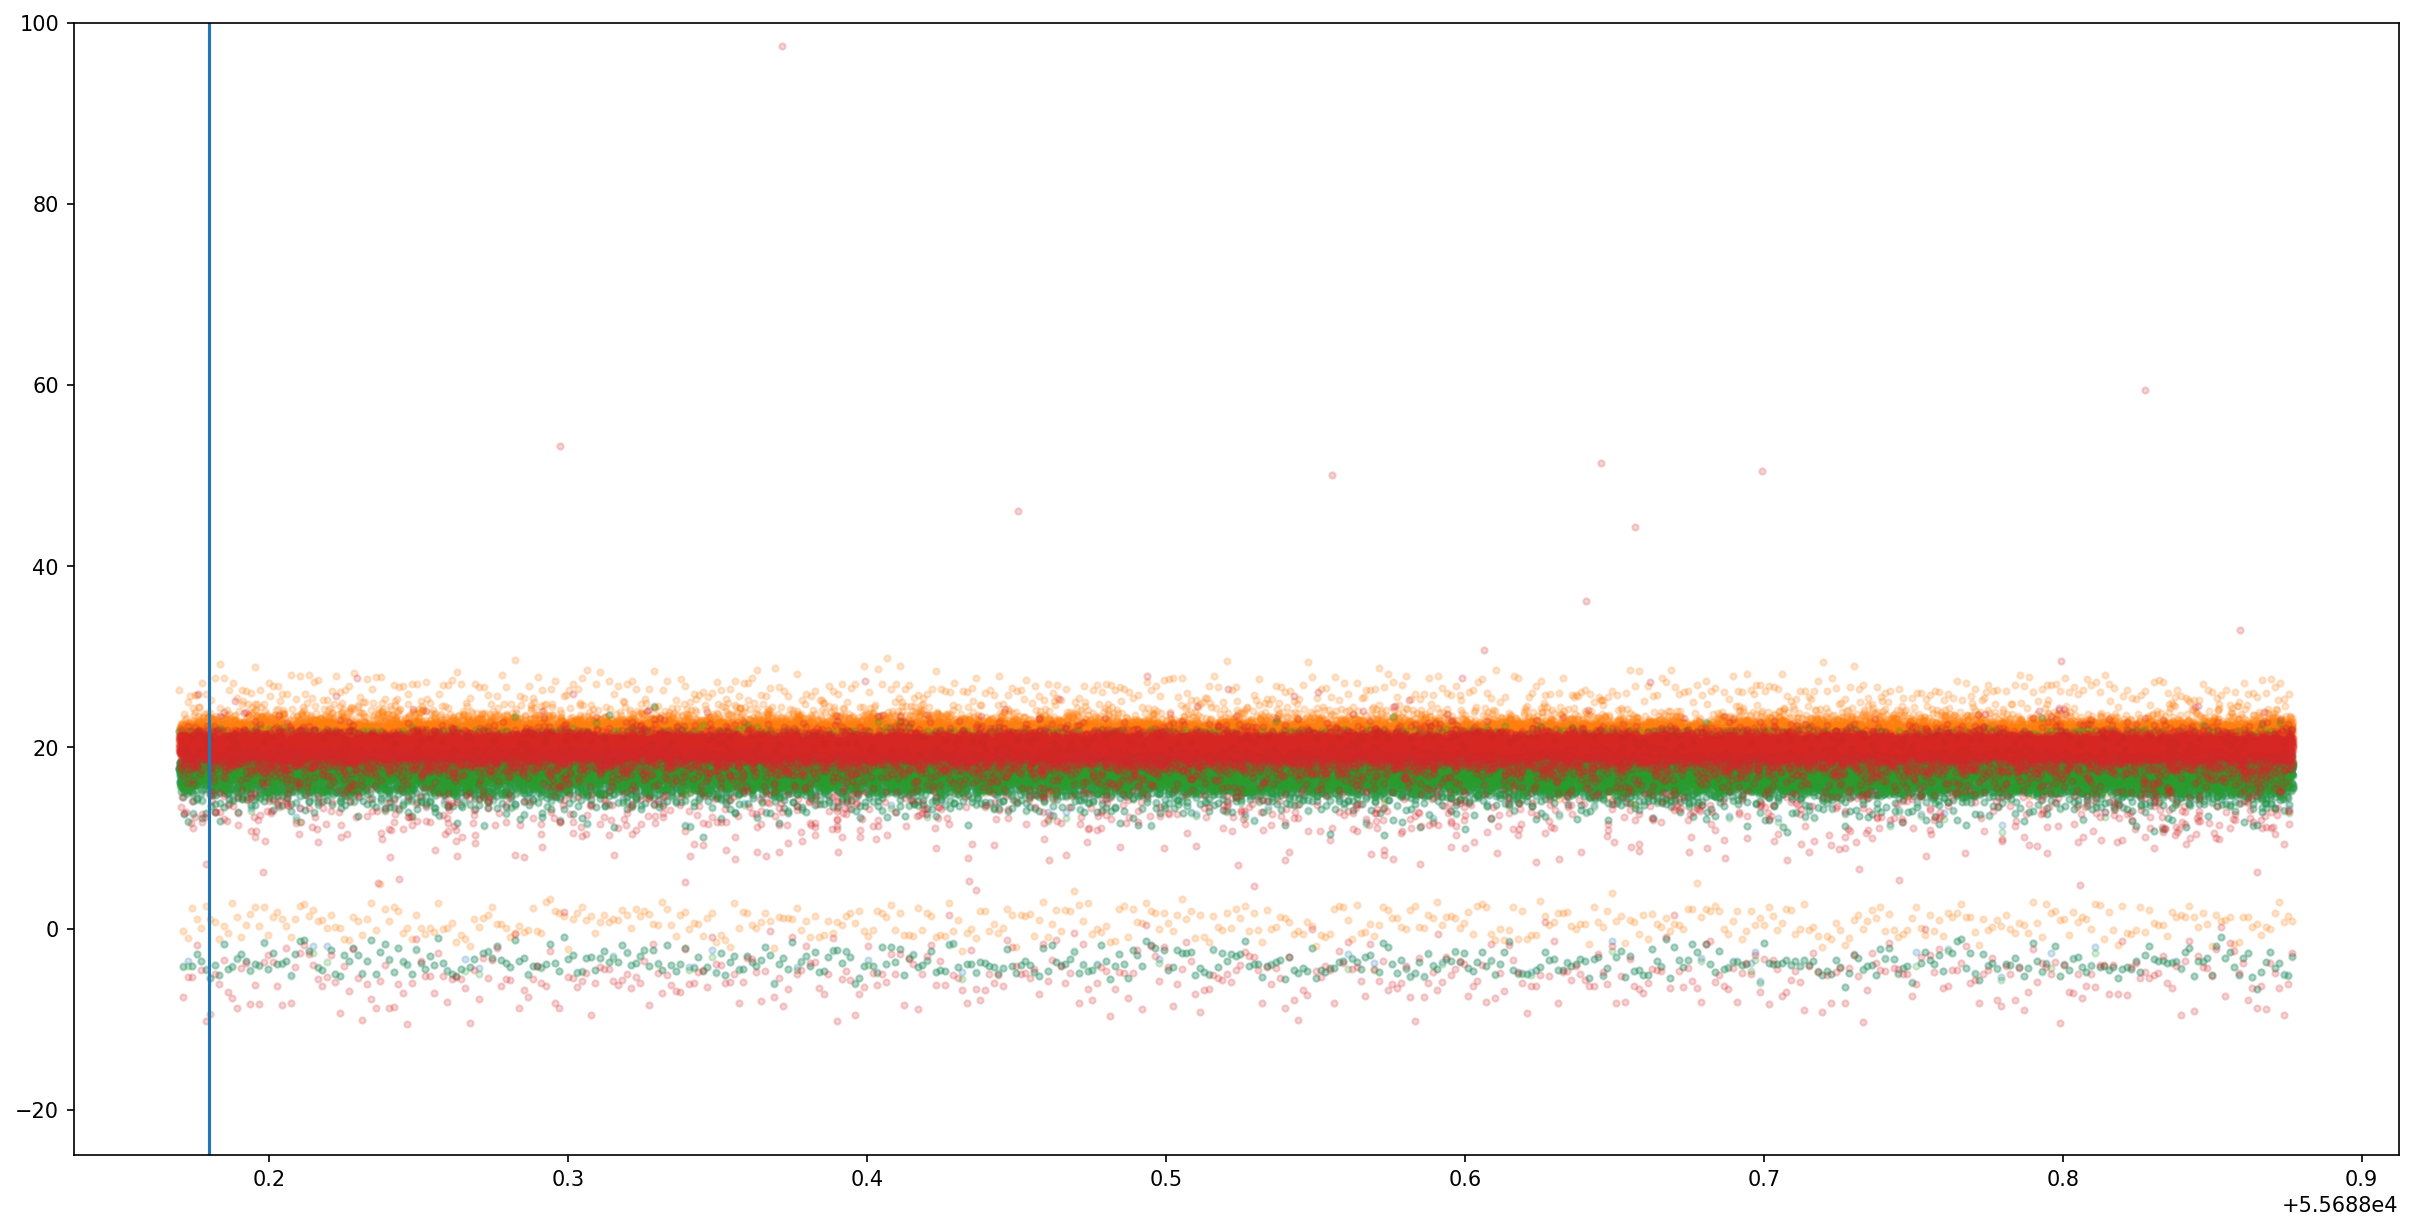

In [83]:
fig = figure(figsize=(20,10))
ax  = fig.add_subplot(111)
ax.plot(example_wanderer_median.timeCube, example_wanderer_median.background_CircleMask,'.',alpha=0.2)
ax.plot(example_wanderer_median.timeCube, example_wanderer_median.background_Annulus,'.',alpha=0.2)
ax.plot(example_wanderer_median.timeCube, example_wanderer_median.background_MedianMask,'.',alpha=0.2)
ax.plot(example_wanderer_median.timeCube, example_wanderer_median.background_KDEUniv,'.',alpha=0.2)
ax.axvline(example_wanderer_median.timeCube.min()-.01+0.02)
ax.set_ylim(-25,100)
# ax.set_xlim(example_wanderer_median.timeCube.min()-.01,example_wanderer_median.timeCube.min() + .05)

In [86]:
example_wanderer_median.measure_effective_width()
print(example_wanderer_median.effective_widths.mean(), sqrt(example_wanderer_median.effective_widths).mean())

10.22789080314988 3.194422397371498


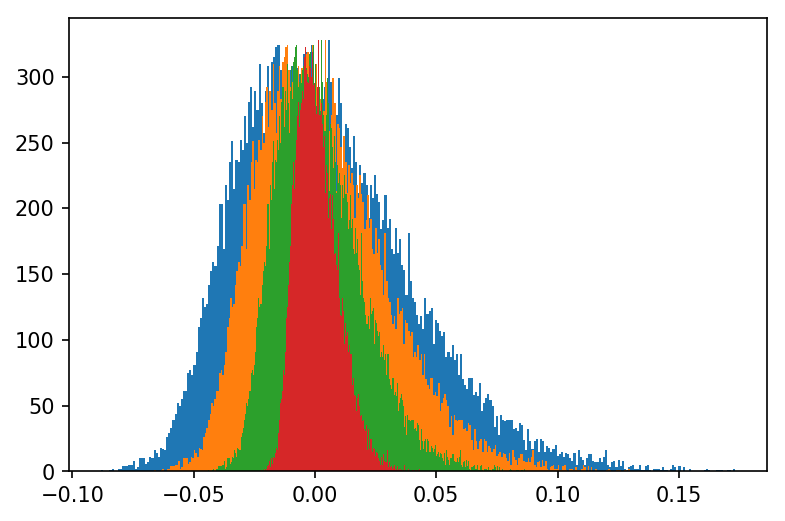

In [87]:
vrad_dist = example_wanderer_median.quadrature_widths - np.median(example_wanderer_median.quadrature_widths)
vrad_dist = clipOutlier2D(vrad_dist, nSig=5)
ax = figure().add_subplot(111)
ax.hist(vrad_dist, bins=example_wanderer_median.nFrames//100);
ax.hist(0.75*vrad_dist, bins=example_wanderer_median.nFrames//100);
ax.hist(0.5*vrad_dist, bins=example_wanderer_median.nFrames//100);
ax.hist(0.25*vrad_dist, bins=example_wanderer_median.nFrames//100);
# ax.set_xlim(-.25,.25);

In [88]:
print('Pipeline took {} seconds thus far'.format(time() - startFull))

Pipeline took 4386.945176124573 seconds thus far


In [89]:
print('Iterating over Background Techniques, Centering Techniques, Aperture Radii' + '\n')
centering_choices  = ['Gaussian_Fit']#, 'Gaussian_Mom', 'FluxWeighted']#, 'LeastAsymmetry']
background_choices = ['AnnularMask']#example_wanderer_median.background_df.columns
staticRads         = np.arange(1, 6,0.5)#[1.0 ]# aperRads = np.arange(1, 6,0.5)
varRads            = [0.0, 0.25, 0.50, 0.75, 1.0, 1.25, 1.50]#[None]# 

vrad_dist = example_wanderer_median.quadrature_widths - np.median(example_wanderer_median.quadrature_widths)
vrad_dist = clipOutlier2D(vrad_dist, nSig=5)

for staticRad in tqdm_notebook(staticRads, total=len(staticRads), desc='Static'):
    for varRad in tqdm_notebook(varRads, total=len(varRads), desc='Variable'):
        startMPFlux = time()
        example_wanderer_median.mp_compute_flux_over_time_varRad(staticRad, varRad, centering_choices[0], \
                                                          background_choices[0], useTheForce=True)
        
        # print('Flux Measurements took {} seconds for sRad {} and vRad {}'.format(time()-startMPFlux,staticRad,varRad))

Iterating over Background Techniques, Centering Techniques, Aperture Radii



**Create Beta Variable Radius**

Gaussian_Fit_AnnularMask_rad_betaRad_0.0_0.0

In [94]:
example_wanderer_median.mp_compute_flux_over_time_betaRad()

In [90]:
print('Entire Pipeline took {} seconds'.format(time() - startFull))

Entire Pipeline took 5944.303172111511 seconds


In [91]:
example_wanderer_median.mp_DBScan_Flux_All()

(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)
(30208, 3)


In [98]:
inlier_master = array(list(example_wanderer_median.inliers_Phots.values())).mean(axis=0) == 1.0

In [99]:
((~inlier_master).sum() / inlier_master.size)*100

0.4435911016949153

In [100]:
example_wanderer_median.extract_PLD_components()

In [101]:
example_wanderer_median.mp_DBScan_PLD_All()

In [112]:
print('Saving `example_wanderer_median` to a set of pickles for various Image Cubes and the Storage Dictionary')

savefiledir         = environ['HOME']+'/Research/Planets/'+planetName+'/ExtracedData/' + channel 
saveFileNameHeader  = planetName+'_'+ AORNow +'_Median'
saveFileType        = '.joblib.save'

if not path.exists(environ['HOME']+'/Research/Planets/'+planetName+'/ExtracedData/'):
    mkdir(environ['HOME']+'/Research/Planets/'+planetName+'/ExtracedData/')

if not path.exists(savefiledir):
    print('Creating ' + savefiledir)
    mkdir(savefiledir)

print()
print('Saving to ' + savefiledir + saveFileNameHeader + saveFileType)
print()

example_wanderer_median.save_data_to_save_files(savefiledir=savefiledir, \
                                                saveFileNameHeader=saveFileNameHeader, \
                                                saveFileType=saveFileType)

Saving `example_wanderer_median` to a set of pickles for various Image Cubes and the Storage Dictionary
Creating /Users/jfraine/Research/Planets/GJ1214/ExtracedData/ch2

Saving to /Users/jfraine/Research/Planets/GJ1214/ExtracedData/ch2GJ1214_r42048000_Median.joblib.save

Storing in `self.save_dict`: 
	self.tqdm
	self.method
	self.filetype
	self.y
	self.x
	self.day2sec
	self.metric
	self.fitsFileDir
	self.fitsFilenames
	self.nSlopeFiles
	self.telescope
	self.centering_df
	self.background_df
	self.flux_TSO_df
	self.noise_TSO_df
	self.yguess
	self.xguess
	self.npix
	self.nCores
	self.AOR
	self.planetName
	self.channel
	self.nFrames
	self.imageCube
	self.noiseCube
	self.timeCube
	self.imageBadPixMasks
	self.imageCubeMedian
	self.imageCubeMAD
	self.centering_FluxWeight
	self.centering_GaussianFit
	self.widths_GaussianFit
	self.heights_GaussianFit
	self.background_GaussianFit
	self.background_CircleMask
	self.background_Annulus
	self.background_KDEUniv
	self.background_MedianMask
	self.effec

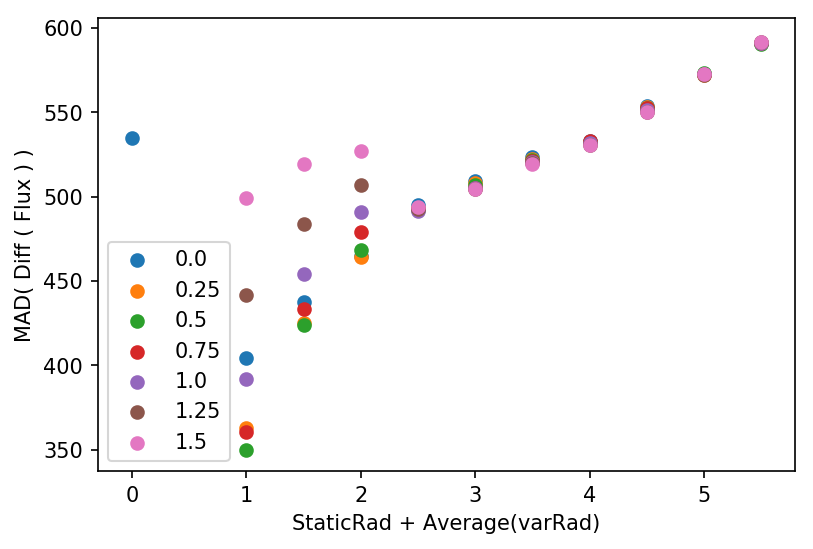

In [130]:
quad_width= example_wanderer_median.quadrature_widths.values
vrad_dist = quad_width - np.median(quad_width)
vrad_dist = clipOutlier2D(vrad_dist, nSig=5)
vrad_dist_med = np.median(vrad_dist)

color_cycle = rcParams['axes.prop_cycle'].by_key()['color']

ax = figure().add_subplot(111)
for key in example_wanderer_median.flux_TSO_df.keys():
    staticRad = float(key.split('_')[-2])
    varRad    = float(key.split('_')[-1])
    aperRad   = staticRad + varRad*vrad_dist_med
    colorNow  = color_cycle[int(varRad*4)]
    # if aperRad > 1.5 and aperRad < 3.5:
    ax.scatter(aperRad, scale.mad(np.diff(example_wanderer_median.flux_TSO_df[key])), \
                   color=colorNow, zorder=int(varRad*4))

for varRad in [0.,0.25, 0.5, 0.75, 1.0, 1.25, 1.5]:
    colorNow  = color_cycle[int(varRad*4)]
    ax.scatter([],[], color=colorNow, label=varRad)

ax.set_xlabel('StaticRad + Average(varRad)')
ax.set_ylabel('MAD( Diff ( Flux ) )')
ax.legend(loc=0)
# ax.set_ylim(292.5,294)
# ax.set_xlim(2.9, 3.1)

In [131]:
print('Entire Pipeline took {} seconds'.format(time() - startFull))

Entire Pipeline took 9365.835044145584 seconds
